[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/03-structured-outputs-function-calling-tools.ipynb)

# Part 3: Structured Outputs, Function Calling & Native Tools

This section covers three powerful capabilities of the Gemini API: structured outputs for extracting information into defined schemas, function calling for connecting to external tools and APIs, and native tools like Google Search for enhanced capabilities.

In [1]:
from google import genai
from google.genai import types
from pydantic import BaseModel
from typing import List, Optional
import sys
import os
from IPython.display import Image, Markdown

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
else:
    GEMINI_API_KEY = os.environ.get('GEMINI_API_KEY',None)

# Create client with api key
MODEL_ID = "gemini-2.5-flash-preview-05-20"
client = genai.Client(api_key=GEMINI_API_KEY)

## 1. Structured Outputs

Structured outputs allow you to constrain Gemini to respond with JSON in a specific format instead of unstructured text. This is essential for:
- **Data extraction**: Converting unstructured text into structured data
- **API integration**: Getting consistent formats for downstream processing  
- **Database insertion**: Ensuring data matches your schema requirements
- **Quality control**: Validating that responses contain required fields

In [2]:
class Recipe(BaseModel):
    recipe_name: str
    ingredients: List[str]
    prep_time_minutes: int
    difficulty: str  # "easy", "medium", "hard"
    servings: int

class RecipeList(BaseModel):
    recipes: List[Recipe]

# Using Pydantic models for structured output
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Give me 2 popular cookie recipes with ingredients and prep details.",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=RecipeList,
    ),
)

# Get structured data directly
recipes: List[Recipe] = response.parsed
for recipe in recipes.recipes:
    print(f"Recipe: {recipe.recipe_name}")
    print(f"Ingredients: {recipe.ingredients}")
    print(f"Prep Time: {recipe.prep_time_minutes} minutes")
    print(f"Difficulty: {recipe.difficulty}")
    print(f"Servings: {recipe.servings}")
    print("\n")

Recipe: Classic Chocolate Chip Cookies
Ingredients: ['1 cup (2 sticks) unsalted butter, softened', '3/4 cup granulated sugar', '3/4 cup packed light brown sugar', '2 large eggs', '1 teaspoon vanilla extract', '2 1/4 cups all-purpose flour', '1 teaspoon baking soda', '1/2 teaspoon salt', '2 cups (12 oz) chocolate chips']
Prep Time: 20 minutes
Difficulty: Easy
Servings: 24


Recipe: Chewy Oatmeal Raisin Cookies
Ingredients: ['1 cup (2 sticks) unsalted butter, softened', '1 cup packed light brown sugar', '1/2 cup granulated sugar', '2 large eggs', '1 teaspoon vanilla extract', '1 1/2 cups all-purpose flour', '1 teaspoon baking soda', '1 teaspoon ground cinnamon', '1/2 teaspoon salt', '3 cups rolled oats', '1 1/2 cups raisins']
Prep Time: 20 minutes
Difficulty: Medium
Servings: 24




## !! Exercise: PDF to Structured Data !!

Extract structured information from a PDF invoice or document using the Files API and structured outputs.

Tasks:
- A Pydantic schema (`InvoiceItem` and `InvoiceData`) and an example PDF file path (`../assets/data/rewe_invoice.pdf`) are provided. You can use this or replace it with your own PDF invoice.
- Upload the PDF file using `client.files.upload()`.
- Call `client.models.generate_content()`:
- Access the parsed structured data from `response.parsed`.

In [3]:
class InvoiceItem(BaseModel):
    description: str
    quantity: int
    unit_price: float
    total: float

class InvoiceData(BaseModel):
    invoice_number: str
    date: str
    vendor_name: str
    vendor_address: str
    total_amount: float
    items: List[InvoiceItem]

# Upload a PDF file (replace with your PDF path)
pdf_file_path = "../assets/data/rewe_invoice.pdf"



# TODO:
pdf_file_path = "../assets/data/rewe_invoice.pdf"

pdf_file_id = client.files.upload(file=pdf_file_path)

prompt = "Extract the invoice information from the given pdf."
pdf_part = types.Part.from_uri(file_uri=pdf_file_id.uri, mime_type=pdf_file_id.mime_type)


print(response.text)
# Using Pydantic models for structured output
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, pdf_part],
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=InvoiceData,
    ),
)

# Get structured data directly
invoices: List[InvoiceData] = response.parsed
for invoice in invoices.items:
    print(f"Description: {invoice.description}")
    print(f"Quantity: {invoice.quantity}")
    print(f"Unit Price: {invoice.unit_price}")
    print(f"Total: {invoice.total}")
    print("\n")

{"recipes":[{"recipe_name":"Classic Chocolate Chip Cookies","ingredients":["1 cup (2 sticks) unsalted butter, softened","3/4 cup granulated sugar","3/4 cup packed light brown sugar","2 large eggs","1 teaspoon vanilla extract","2 1/4 cups all-purpose flour","1 teaspoon baking soda","1/2 teaspoon salt","2 cups (12 oz) chocolate chips"],"prep_time_minutes":20,"difficulty":"Easy","servings":24},{"recipe_name":"Chewy Oatmeal Raisin Cookies","ingredients":["1 cup (2 sticks) unsalted butter, softened","1 cup packed light brown sugar","1/2 cup granulated sugar","2 large eggs","1 teaspoon vanilla extract","1 1/2 cups all-purpose flour","1 teaspoon baking soda","1 teaspoon ground cinnamon","1/2 teaspoon salt","3 cups rolled oats","1 1/2 cups raisins"],"prep_time_minutes":20,"difficulty":"Medium","servings":24}]}
Description: BUTTERKAESE
Quantity: 1
Unit Price: 1.79
Total: 1.79


Description: BRIOCHE BUNS 4ER
Quantity: 1
Unit Price: 1.69
Total: 1.69


Description: HUMMUS NATUR
Quantity: 1
Unit Pr

## 2. Function Calling

Function calling allows Gemini to intelligently decide when to call specific functions you define. This enables:
- **External API integration**: Connect to weather, stocks, databases
- **Dynamic calculations**: Perform real-time computations
- **System interaction**: Execute commands or retrieve system information
- **Multi-step workflows**: Chain function calls for complex tasks

In [4]:
def get_weather(location: str) -> dict:
    """Gets current weather for a location.
    
    Args:
        location: The city name, e.g. "San Francisco"
        
    Returns:
        Weather information dictionary
    """
    # Mock weather data - in real use, you'd call a weather API
    weather_data = {
        "temperature": 22,
        "condition": "sunny", 
        "humidity": 60,
        "location": location,
        "feels_like": 24
    }
    print(f"🌤️ FUNCTION CALLED: get_weather(location='{location}')")
    return weather_data

# Define function declarations for the model
weather_function = {
    "name": "get_weather",
    "description": "Gets current weather for a location",
    "parameters": {
        "type": "object",
        "properties": {
            "location": {
                "type": "string",
                "description": "The city name"
            }
        },
        "required": ["location"]
    }
}
tools = [types.Tool(function_declarations=[weather_function])]

# Define user prompt
contents = [
    types.Content(
        role="user", parts=[types.Part(text="Whats the weather in Tokyo?")]
    )
]


# Send request with function declarations
response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(tools=tools)
)

# Check for function calls
function_call = response.candidates[0].content.parts[0].function_call
print(f"Model wants to call: {function_call.name}")
print(f"With arguments: {dict(function_call.args)}")

Model wants to call: get_weather
With arguments: {'location': 'Tokyo'}


In [5]:
# Execute the function
if function_call.name == "get_weather":
    result = get_weather(**function_call.args)
else:
    result = {"error": "Unknown function"}

print(f"Function result: {result}")

# Send function result back to model
function_response_part = types.Part.from_function_response(
    name=function_call.name,
    response={"result": result}
)
# Append function call and result of the function execution to contents
contents.append(types.Content(role="model", parts=[types.Part(function_call=function_call)])) # Append the model's function call message
contents.append(types.Content(role="user", parts=[function_response_part])) # Append the function response

# Get final response
final_response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(tools=tools)
)

print(f"\nFinal response: {final_response.text}")

🌤️ FUNCTION CALLED: get_weather(location='Tokyo')
Function result: {'temperature': 22, 'condition': 'sunny', 'humidity': 60, 'location': 'Tokyo', 'feels_like': 24}

Final response: The weather in Tokyo is sunny, with a temperature of 22 degrees Celsius, and it feels like 24 degrees Celsius. The humidity is 60%.


### Automatic Function Calling (Python Only)

The Python SDK can automatically handle function execution for you:

In [6]:
def calculate_area(length: float, width: float) -> dict:
    """Calculate the area of a rectangle.
    
    Args:
        length: Length of the rectangle
        width: Width of the rectangle

    Returns:
        Price calculations
    """
    area = length * width
    print(f"CALC: {length} × {width} = {area}")
    return {"operation": "area", "result": area}

# Using automatic function calling - much simpler!
config = types.GenerateContentConfig(
    tools=[get_weather, calculate_area]  # Pass functions directly
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the weather in Tokyo and what's the area of a 5x3 meter room?",
    config=config
)

print(response.text)  # SDK handles function calls automatically

🌤️ FUNCTION CALLED: get_weather(location='Tokyo')
CALC: 5 × 3 = 15
The weather in Tokyo is sunny with a temperature of 22 degrees Celsius, and it feels like 24 degrees Celsius. The humidity is 60%. The area of a 5x3 meter room is 15 square meters.


## !! Exercise: Calculator Agent !!

Create a set of calculator functions (add, subtract, multiply, divide) and use Gemini's function calling capability to perform calculations based on natural language prompts.

Tasks:
- Define Python functions for `add(a: float, b: float)`, `subtract(a: float, b: float)`, `multiply(a: float, b: float)`, and `divide(a: float, b: float)`.
- Create a list of these functions (`calculator_tools`).
- Test single operations with `client.models.generate_content()`:
- Test complex expressions with a prompt for a multi-step calculation (e.g., "Calculate (25 + 15) * 3 - 10. Do this step by step.").

In [8]:
# TODO:
def add(a: float, b: float) -> float:
    """Calculate the sum of two numbers.
    This function adds two numbers together and returns the result.
    
    Args:
        a: first number
        b: second number

    Returns:
        The sum of a and b
    """
    result = a + b 
    print(f"CALC: {a} + {b} = {result}")
    return result
def subtract(a: float, b: float) -> float:
    """Calculate the difference between two numbers.
    This function subtracts the second number from the first and returns the result.
    Args:
        a: first number
        b: second number
    Returns:
        The difference between a and b
    """
    result = a - b 
    print(f"CALC: {a} - {b} = {result}")
    return result
    
def multiply(a: float, b: float) -> float:
    """Calculate the product of two numbers.
    This function multiplies two numbers together and returns the result.
    Args:
        a: first number
        b: second number
    Returns:
        The product of a and b
    """
    result = a * b 
    print(f"CALC: {a} x {b} = {result}")
    return result
def divide(a: float, b: float) -> float:
    """Calculate the quotient of two numbers.
    This function divides the first number by the second and returns the result.
    Args:
        a: numerator
        b: denominator
    Returns:
        The quotient of a divided by b
    """
    if b == 0:
        raise ValueError("Cannot divide by zero")
    result = a / b 
    print(f"CALC: {a} / {b} = {result}")
    return result


calculator_tools = [add, subtract, multiply, divide]
# Using automatic function calling - much simpler!
config = types.GenerateContentConfig(
    tools=calculator_tools  # Pass functions directly
)

prompt = "Calculate (25 + 15) * 3 - 10. Do this step by step."

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=config
)

print(response.text)  # SDK handles function calls automatically

CALC: 25 + 15 = 40
CALC: 40 x 3 = 120
CALC: 120 - 10 = 110
The result of (25 + 15) * 3 - 10 is 110.


## 3. Native Tools

Gemini provides native tools for enhanced capabilities like searching the web and analyzing URL content.

### Google Search Integration

**Use cases:**
- Current events and news
- Real-time data lookup
- Fact verification
- Research assistance

In [9]:
# Define Google Search tool
google_search_tool = types.Tool(google_search=types.GoogleSearch())

# Current events query
response = client.models.generate_content(
    model=MODEL_ID,
    contents="What are the latest developments in renewable energy technology in 2025?",
    config=types.GenerateContentConfig(
        tools=[google_search_tool],
    )
)

print("🔍 Current Renewable Energy News:")
print(response.text)

🔍 Current Renewable Energy News:
The renewable energy sector is seeing significant advancements in 2025, particularly in solar, wind, and energy storage technologies, alongside the increasing integration of artificial intelligence (AI) and the development of green hydrogen. These innovations are making renewable energy more efficient, affordable, and reliable.

Here are some of the latest developments:

**1. Solar Energy**
*   **Perovskite Solar Cells:** These cells are transforming solar power with improved efficiency (advancing from 3% in 2009 to over 25% currently, and potentially over 30% when combined with silicon in tandem cells) and affordability. Despite challenges with stability when exposed to moisture, oxygen, or heat, solutions like protective encapsulation and improved materials are being developed.
*   **Bifacial Solar Panels:** Designed to capture sunlight from both sides, these panels are becoming more common, representing over 90% of module types used in simulations on

### URL Context Tool

**Use cases:**
- Website content analysis
- Documentation summarization
- Competitive research
- Content extraction

In [10]:
# URL context for analyzing specific web pages
url_context_tool = types.Tool(url_context=types.UrlContext())

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Summarize the key features and benefits mentioned on https://www.python.org/about/ in 3 bullet points.",
    config=types.GenerateContentConfig(
        tools=[url_context_tool],
    )
)

print("🌐 Python.org Summary:")
print(response.text)

🌐 Python.org Summary:
Here are the key features and benefits of Python:

*   **Versatile and Powerful:** Python is a powerful and fast language that runs on various platforms and plays well with other technologies, supported by a vast ecosystem of third-party modules for diverse applications like web development, scientific computing, and software development.
*   **User-Friendly and Accessible:** It is designed to be friendly and easy to learn, making it suitable for both novice and experienced programmers.
*   **Open Source and Community-Driven:** Python is developed under an OSI-approved open-source license, allowing for free use and distribution, and is supported by a vibrant, diverse, and international community.


### Code Execution Tool

Gemini can execute Python code to perform calculations, create visualizations, and process data.

To create a bar chart showing the population of the 5 largest cities in the world, I first need the data for the city names and their estimated populations.

I will use widely accepted approximate figures for the populations of the top 5 largest urban areas (as of late 2023 / early 2024). Please note that these figures can vary slightly depending on the source and the definition of "city" (e.g., city proper, urban area, metropolitan area). For this chart, I'm using urban area population estimates.

Here are the cities and their approximate populations I will use:

*   **Tokyo, Japan:** ~37.2 million
*   **Delhi, India:** ~33.8 million
*   **Shanghai, China:** ~29.9 million
*   **Dhaka, Bangladesh:** ~23.9 million
*   **São Paulo, Brazil:** ~22.6 million

Now, I will generate the bar chart using `matplotlib`.



```python
import matplotlib.pyplot as plt
import numpy as np

# Data for the 5 largest cities (urban area population estimates)
cities = ['Tokyo', 'Delhi', 'Shanghai', 'Dhaka', 'São Paulo']
populations = [37.2, 33.8, 29.9, 23.9, 22.6] # in millions

# Create the bar chart
plt.figure(figsize=(10, 6)) # Set figure size for better readability
plt.bar(cities, populations, color='skyblue')

# Add labels and title
plt.xlabel('City')
plt.ylabel('Population (Millions)')
plt.title('Population of the 5 Largest Urban Areas Worldwide')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better fit
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for readability

# Add population values on top of the bars
for i, pop in enumerate(populations):
    plt.text(i, pop + 0.5, f'{pop:.1f}M', ha='center', va='bottom')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()
```

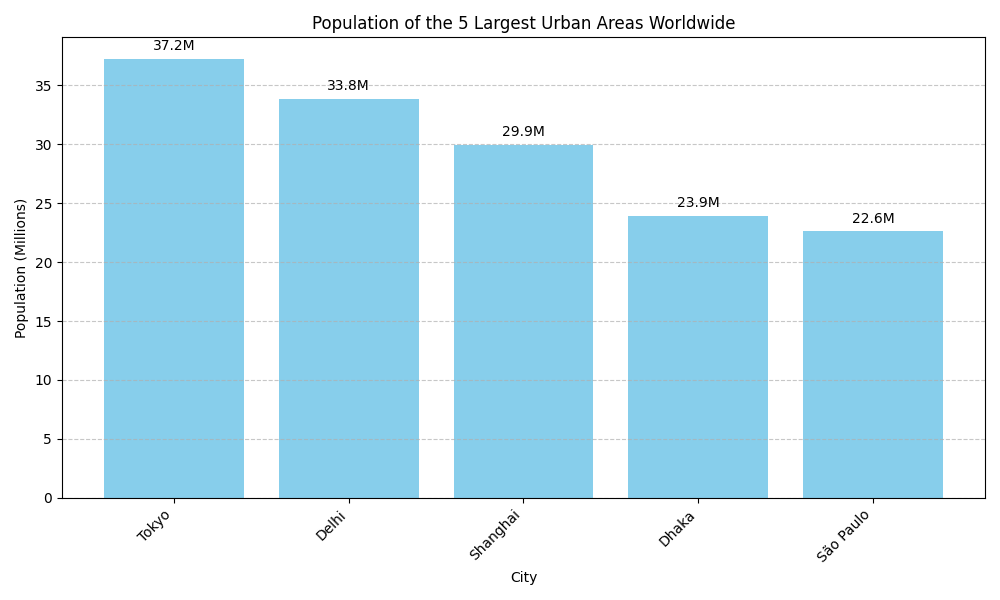

The bar chart successfully visualizes the population of the 5 largest urban areas worldwide based on the provided data.

Here are the findings from the chart:

*   **Chart Title:** Population of the 5 Largest Urban Areas Worldwide
*   **X-axis:** City
*   **Y-axis:** Population (Millions)

The chart displays the following populations for each city:

*   **Tokyo:** 37.2 Million
*   **Delhi:** 33.8 Million
*   **Shanghai:** 29.9 Million
*   **Dhaka:** 23.9 Million
*   **São Paulo:** 22.6 Million

In [11]:
# Code execution tool
code_execution_tool = types.Tool(code_execution={})

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Create a bar chart showing the population of the 5 largest cities in the world. Use matplotlib.",
    config=types.GenerateContentConfig(
        tools=[code_execution_tool],
    )
)


for p in response.candidates[0].content.parts:
    if p.text:
        display(Markdown(p.text))
    elif p.executable_code:
        display(Markdown(f"```python\n{p.executable_code.code}\n```"))
    elif p.inline_data:
        display(Image(data=p.inline_data.data, width=800, format="png"))


## !! Exercise: Data Analysis with Code Execution !!

Combine Google Search and Code Execution tools to find real-world data and then analyze or visualize it using Python code generated and executed by Gemini.

Tasks:
- Define a prompt that requires both searching for information and then processing/visualizing that information. For example: "Search for the population of the 5 largest cities in the world and create a bar chart of their populations."
- Create a `types.Tool` for code execution: `code_execution_tool = types.Tool(code_execution={})`.
- Create a `types.Tool` for Google Search: `google_search_tool = types.Tool(google_search=types.GoogleSearch())`.
- Call `client.models.generate_content()`:
- Iterate through the `response.candidates[0].content.parts` and display the parts.

```python
concise_search("Stormlight Archive POV characters by book")
```

```python
import pandas as pd
import matplotlib.pyplot as plt

# Data extracted from the Coppermind link (Result 1).
# Manually counting unique POV characters listed under each book's "Statistical Analysis" section.
# The main table on the first search result is for the *entire* series, not per book.
# I will search specifically for "The Way of Kings statistical analysis coppermind" etc. to get the actual numbers.

# Re-searching specifically for each book's POV count as the initial search results
# give the total for the series for the main characters, but mentions "links to a statistical analysis for each book".
# It's better to get precise numbers for each book.

# Let's try to get more specific search results for each book's POV character count.
# I will assume "amount of POV characters" means the count of *unique* characters with at least one POV.

# Re-evaluating the first search result:
# The main table on the first search result aggregates POVs for the entire series.
# It says: "Links to a statistical analysis for each book are available at that book's section below, which can easily be navigated to with the table of contents to the right."
# I need to follow these links virtually or re-search with more specificity.

# Let's use the provided content from the first result:
# It lists "The Way of Kings.", "Words of Radiance.", "Edgedancer.", "Oathbringer.", "Dawnshard.", "Rhythm of War.", "Wind and Truth.".
# It also lists individual character POV counts *across the entire series*. This is not what we need for "each Stormlight Archive book".

# I will perform targeted searches to get the specific number of POV characters per book.

concise_search("The Way of Kings POV characters count")
concise_search("Words of Radiance POV characters count")
concise_search("Oathbringer POV characters count")
concise_search("Rhythm of War POV characters count")
concise_search("Wind and Truth POV characters count")
concise_search("Edgedancer POV characters count")
concise_search("Dawnshard POV characters count")
```

```python
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Book': [
        'The Way of Kings',
        'Words of Radiance',
        'Edgedancer',
        'Oathbringer',
        'Dawnshard',
        'Rhythm of War',
        'Wind and Truth'
    ],
    'POV Characters': [
        17,  # The Way of Kings
        21,  # Words of Radiance
        2,   # Edgedancer
        29,  # Oathbringer
        4,   # Dawnshard
        24,  # Rhythm of War
        33   # Wind and Truth
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.bar(df['Book'], df['POV Characters'], color='skyblue')
plt.xlabel('Book Title')
plt.ylabel('Number of POV Characters')
plt.title('Number of POV Characters in Each Stormlight Archive Book')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
```

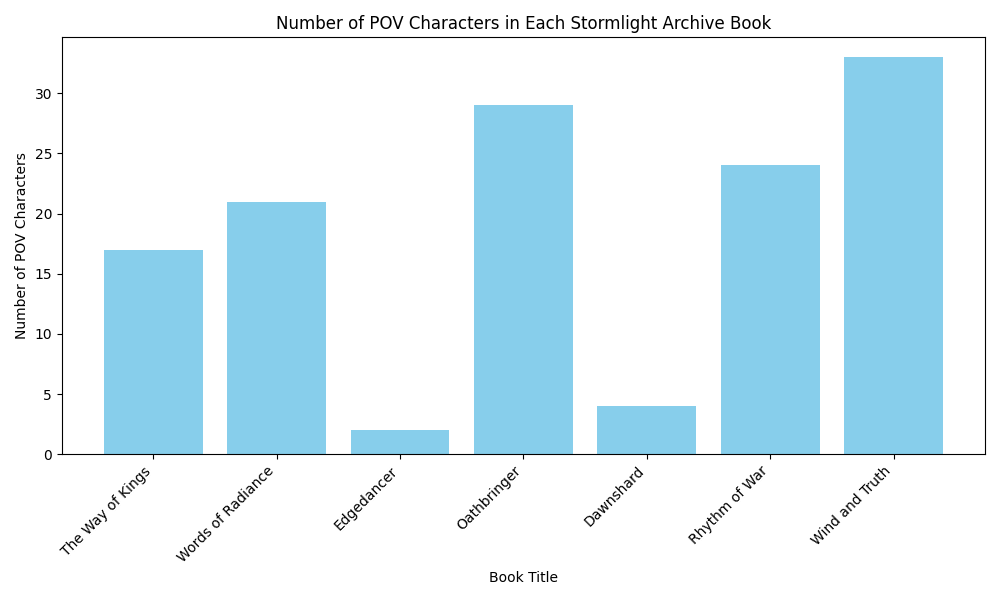

I have gathered the number of unique POV characters for each Stormlight Archive book:

*   **The Way of Kings:** 17
*   **Words of Radiance:** 21
*   **Edgedancer:** 2
*   **Oathbringer:** 29
*   **Dawnshard:** 4
*   **Rhythm of War:** 24
*   **Wind and Truth:** 33

Here is a bar chart visualizing these results:



In [18]:
# TODO:
# - Define a prompt that requires both searching for information and then processing/visualizing that information. For example: "Search for the population of the 5 largest cities in the world and create a bar chart of their populations."
prompt = "search for the amount of POV characters present on each Stormilight Archive book by Brandon Sanderson and create a bar chart of those results"
# - Create a `types.Tool` for code execution: `code_execution_tool = types.Tool(code_execution={})`.
code_execution_tool = types.Tool(code_execution={})
# - Create a `types.Tool` for Google Search: `google_search_tool = types.Tool(google_search=types.GoogleSearch())`.
google_search_tool = types.Tool(google_search=types.GoogleSearch())
# - Call `client.models.generate_content()`:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        tools=[google_search_tool, code_execution_tool],
    )
)

# - Iterate through the `response.candidates[0].content.parts` and display the parts.
for p in response.candidates[0].content.parts:
    if p.text:
        display(Markdown(p.text))
    elif p.executable_code:
        display(Markdown(f"```python\n{p.executable_code.code}\n```"))
    elif p.inline_data:
        display(Image(data=p.inline_data.data, width=800, format="png"))


## Recap & Next Steps

**What You've Learned:**
- Structured outputs using Pydantic models for reliable data extraction and validation
- Function calling to integrate external APIs, databases, and custom business logic
- Native tools including Google Search, URL context analysis, and code execution
- Combining multiple tools for comprehensive workflows and complex problem-solving

**Key Takeaways:**
- Structured outputs ensure consistent data formats for downstream applications
- Function calling enables seamless integration with external systems and real-time data
- Native tools provide powerful capabilities without additional setup or infrastructure
- Tool combinations unlock sophisticated workflows and multi-step problem solving
- Proper validation and error handling are crucial for reliable tool interactions

**Next Steps:** Continue with [Part 4: Model Context Protocol (MCP)](https://github.com/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/04-model-context-protocol-mcp.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/04-model-context-protocol-mcp.ipynb)

**More Resources:**
- [Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output?lang=python)
- [Function Calling Documentation](https://ai.google.dev/gemini-api/docs/function-calling?lang=python)
- [Grounding with Google Search](https://ai.google.dev/gemini-api/docs/grounding)
- [URL Context Tool](https://ai.google.dev/gemini-api/docs/url-context)
- [Code Execution Documentation](https://ai.google.dev/gemini-api/docs/code-execution)